# Task 3: Claim vs Reference vs Context Classification

This notebook implements a machine learning pipeline for classifying scientific tweets into three categories (with possible overlaps):
- Claim
- Context
- Reference

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, make_scorer
)
import optuna
import emoji
import re
import scipy.sparse
import spacy
from langdetect import detect
import joblib

In [ ]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Gaussian NB": GaussianNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score, average='weighted'),
            "Recall": make_scorer(recall_score, average='weighted'),
            "F1 Score": make_scorer(f1_score, average='weighted')
        }
        self.results = {}
        self.best_model = None
        self.vectorizer = None

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        #Test with pre-processing
        if with_preprocessing:
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'

        #Test without pre-processing
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix with token categorization"""
        # TF-IDF Vectorization
        self.vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = self.vectorizer.fit_transform(X_text)
        
        # Categorize tokens
        feature_names = self.vectorizer.get_feature_names_out()
        token_categories = {token: self.get_token_category(token) for token in feature_names}
        
        # Binary features
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        # Combine features
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final
    
    @staticmethod
    def get_token_category(token):
        """Categorize token as numeric, timestamp, or valid"""
        if token.isdigit():
            return 'numeric'
        if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
            return 'timestamp'
        if re.match(r'^[a-zA-Z]+$', token):
            return 'valid'
        return 'other'

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        best_f1 = 0
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            y_array = y.values
            
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y_array), 1):
                X_train = X[train_idx] if scipy.sparse.issparse(X) else X[train_idx]
                X_test = X[test_idx] if scipy.sparse.issparse(X) else X[test_idx]
                y_train = y_array[train_idx]
                y_test = y_array[test_idx]
                
                if isinstance(model, (GaussianNB, XGBClassifier)):
                    X_train = X_train.toarray() if scipy.sparse.issparse(X_train) else X_train
                    X_test = X_test.toarray() if scipy.sparse.issparse(X_test) else X_test
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
                fold_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))
                
                if fold == cv.n_splits:
                    plt.figure(figsize=(8, 6))
                    cm = confusion_matrix(y_test, y_pred)
                    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})\nClaim vs Context vs Ref')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
                    
                    print("\nClassification Report:")
                    print(classification_report(y_test, y_pred, 
                                              target_names=['Claim', 'Context', 'Reference']))
            
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            display(self.vectorizer)
            
            # Track best model
            if metrics["F1"] > best_f1:
                best_f1 = metrics["F1"]
                self.best_model = {
                    'name': name,
                    'model': model,
                    'vectorizer': self.vectorizer  
                }
            
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_task3_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df

    def save_best_model(self):
        """Save the best performing model"""
        if self.best_model is None:
            print("No best model found. Please run train_and_evaluate first.")
            return
        
        print(f"\nSaving best model: {self.best_model['name']}")
        joblib.dump(self.best_model, 'best_model_task3.joblib')
        print("Model saved successfully!")

Loading data...

Distribution of classes (with overlaps):
label_text
CLAIM      263
CONTEXT    251
REF        203
Name: count, dtype: int64

Mapping used: {'CLAIM': 0, 'CONTEXT': 1, 'REF': 2}


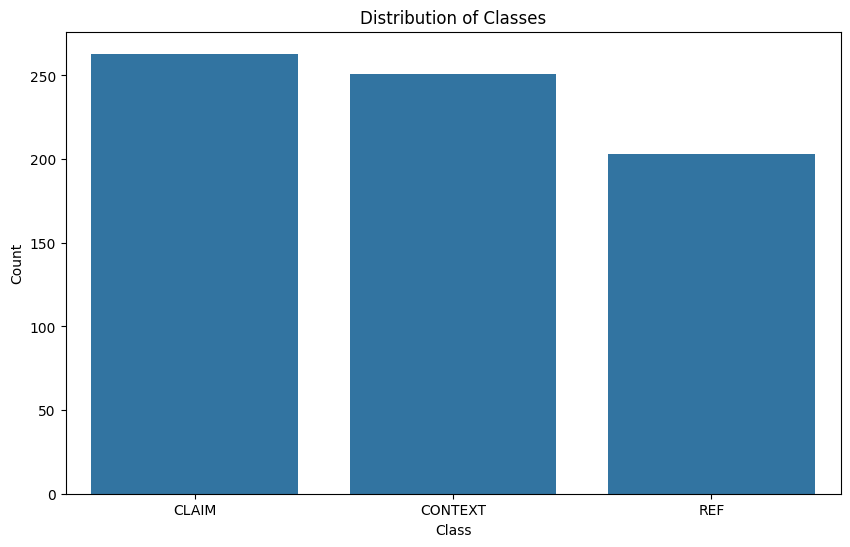

In [9]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_export.tsv', sep='\t')

# Filter scientific tweets only
df_sci = df[df['science_related'] == 1].copy()

# Create separate groups with overlaps allowed
claim = df_sci[df_sci["scientific_claim"] == 1.0].copy()
claim["label_text"] = "CLAIM"

context = df_sci[df_sci["scientific_context"] == 1.0].copy()
context["label_text"] = "CONTEXT"

ref = df_sci[df_sci["scientific_reference"] == 1.0].copy()
ref["label_text"] = "REF"

# Combine all groups (allowing overlaps)
df_multi = pd.concat([claim, context, ref], ignore_index=True)

# Encode labels
label_map = {"CLAIM": 0, "CONTEXT": 1, "REF": 2}
df_multi["label"] = df_multi["label_text"].map(label_map)

# Display statistics
print("\nDistribution of classes (with overlaps):")
print(df_multi["label_text"].value_counts())
print("\nMapping used:", label_map)

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_multi, x='label_text')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

=== Training Model ===

🔍 Training model: Gaussian NB


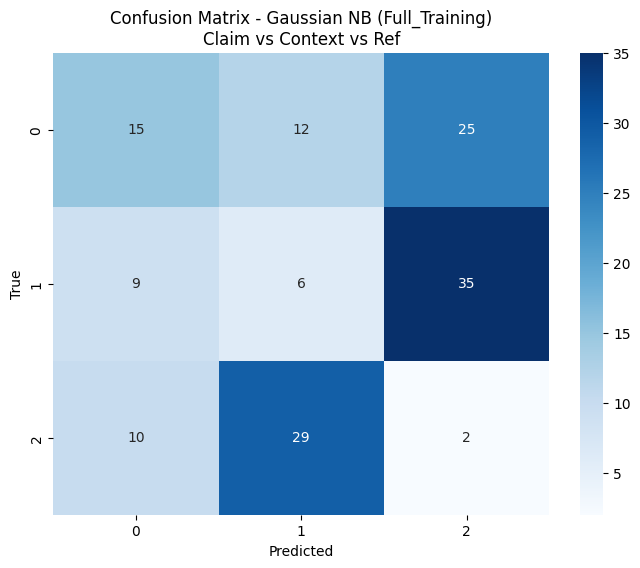


Classification Report:
              precision    recall  f1-score   support

       Claim       0.44      0.29      0.35        52
     Context       0.13      0.12      0.12        50
   Reference       0.03      0.05      0.04        41

    accuracy                           0.16       143
   macro avg       0.20      0.15      0.17       143
weighted avg       0.21      0.16      0.18       143

Accuracy: 0.1729 ± 0.0231
Precision: 0.2132 ± 0.0329
Recall: 0.1729 ± 0.0231
F1: 0.1873 ± 0.0231


TfidfVectorizer(max_features=10000)


🔍 Training model: Random Forest


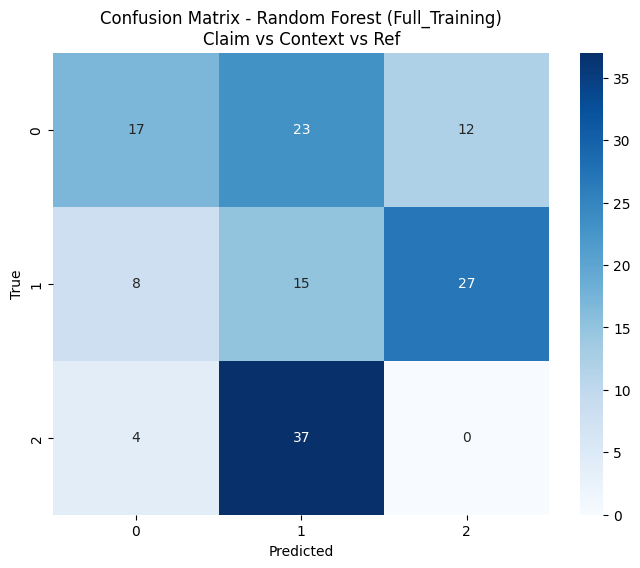


Classification Report:
              precision    recall  f1-score   support

       Claim       0.59      0.33      0.42        52
     Context       0.20      0.30      0.24        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.22       143
   macro avg       0.26      0.21      0.22       143
weighted avg       0.28      0.22      0.24       143

Accuracy: 0.2078 ± 0.0207
Precision: 0.2226 ± 0.0319
Recall: 0.2078 ± 0.0207
F1: 0.2098 ± 0.0167


TfidfVectorizer(max_features=10000)


🔍 Training model: SVM


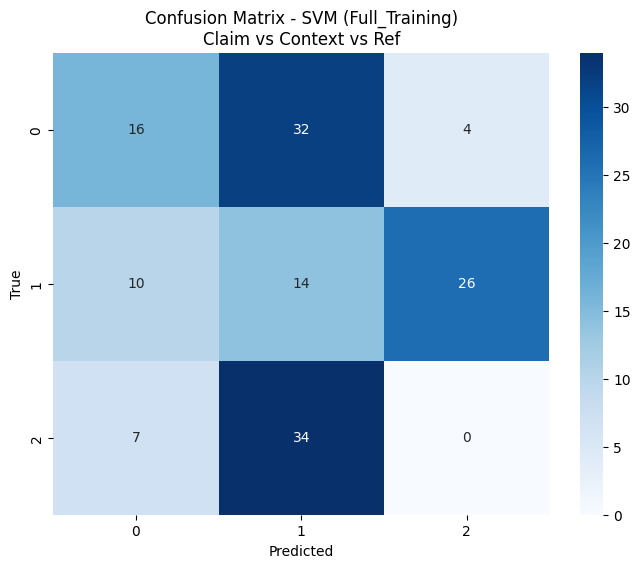


Classification Report:
              precision    recall  f1-score   support

       Claim       0.48      0.31      0.38        52
     Context       0.17      0.28      0.22        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.21       143
   macro avg       0.22      0.20      0.20       143
weighted avg       0.24      0.21      0.21       143

Accuracy: 0.2204 ± 0.0200
Precision: 0.2202 ± 0.0120
Recall: 0.2204 ± 0.0200
F1: 0.2153 ± 0.0105


TfidfVectorizer(max_features=10000)


🔍 Training model: KNN


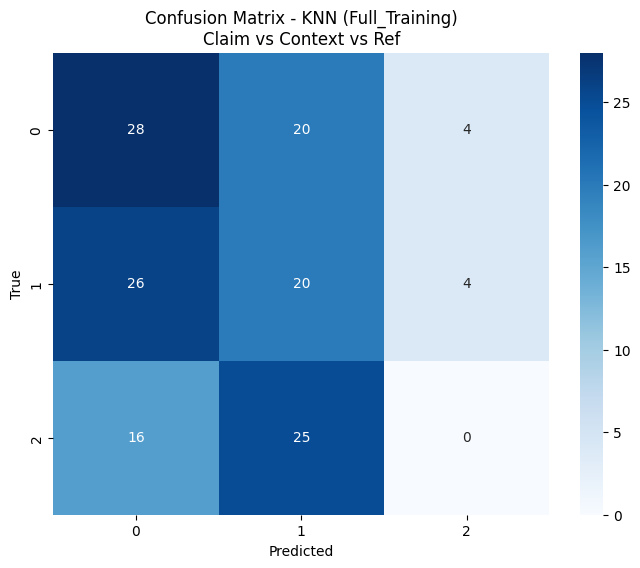


Classification Report:
              precision    recall  f1-score   support

       Claim       0.40      0.54      0.46        52
     Context       0.31      0.40      0.35        50
   Reference       0.00      0.00      0.00        41

    accuracy                           0.34       143
   macro avg       0.24      0.31      0.27       143
weighted avg       0.25      0.34      0.29       143

Accuracy: 0.3236 ± 0.0209
Precision: 0.2741 ± 0.0263
Recall: 0.3236 ± 0.0209
F1: 0.2853 ± 0.0168


TfidfVectorizer(max_features=10000)


🔍 Training model: AdaBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


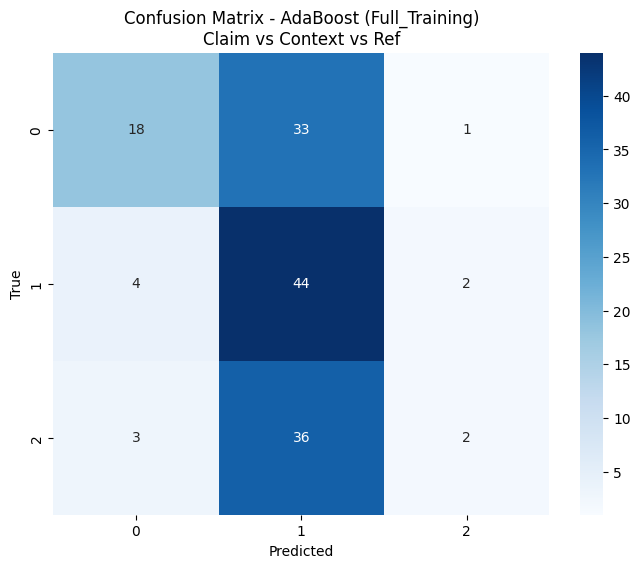


Classification Report:
              precision    recall  f1-score   support

       Claim       0.72      0.35      0.47        52
     Context       0.39      0.88      0.54        50
   Reference       0.40      0.05      0.09        41

    accuracy                           0.45       143
   macro avg       0.50      0.42      0.36       143
weighted avg       0.51      0.45      0.38       143

Accuracy: 0.4365 ± 0.0081
Precision: 0.4081 ± 0.0692
Recall: 0.4365 ± 0.0081
F1: 0.3704 ± 0.0138


TfidfVectorizer(max_features=10000)


🔍 Training model: XGBoost


/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:18:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:18:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:18:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/etienne/Bureau/ML/Machine_learning/Projet/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:18:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_en

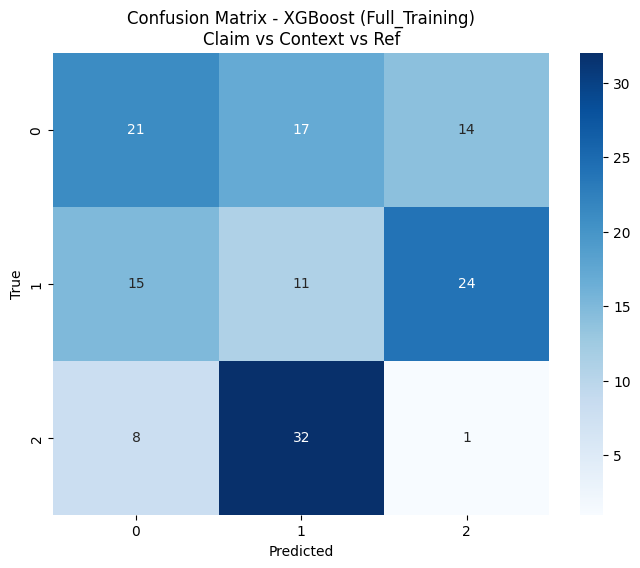


Classification Report:
              precision    recall  f1-score   support

       Claim       0.48      0.40      0.44        52
     Context       0.18      0.22      0.20        50
   Reference       0.03      0.02      0.03        41

    accuracy                           0.23       143
   macro avg       0.23      0.22      0.22       143
weighted avg       0.25      0.23      0.24       143

Accuracy: 0.2120 ± 0.0307
Precision: 0.2124 ± 0.0179
Recall: 0.2120 ± 0.0307
F1: 0.2101 ± 0.0193


TfidfVectorizer(max_features=10000)


🔍 Training model: Neural Network - MLP


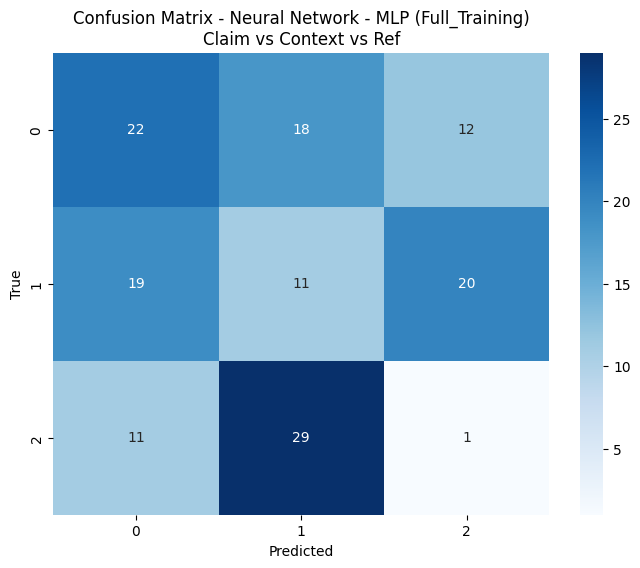


Classification Report:
              precision    recall  f1-score   support

       Claim       0.42      0.42      0.42        52
     Context       0.19      0.22      0.20        50
   Reference       0.03      0.02      0.03        41

    accuracy                           0.24       143
   macro avg       0.21      0.22      0.22       143
weighted avg       0.23      0.24      0.23       143

Accuracy: 0.2231 ± 0.0279
Precision: 0.2235 ± 0.0187
Recall: 0.2231 ± 0.0279
F1: 0.2183 ± 0.0127


TfidfVectorizer(max_features=10000)


Results:


,Model,Phase,Accuracy,Accuracy_Std,Precision,Precision_Std,Recall,Recall_Std,F1,F1_Std
0,Gaussian NB,Full_Training,0.172892,0.023075,0.213192,0.032941,0.172892,0.023075,0.187255,0.023136
1,Random Forest,Full_Training,0.207799,0.020726,0.222619,0.031863,0.207799,0.020726,0.209812,0.016740
2,SVM,Full_Training,0.220367,0.020026,0.220244,0.011981,0.220367,0.020026,0.215309,0.010472
3,KNN,Full_Training,0.323631,0.020934,0.274128,0.026310,0.323631,0.020934,0.285323,0.016815
4,AdaBoost,Full_Training,0.436538,0.008096,0.408104,0.069162,0.436538,0.008096,0.370372,0.013762
5,XGBoost,Full_Training,0.211956,0.030726,0.212409,0.017918,0.211956,0.030726,0.210098,0.019262
6,Neural Network - MLP,Full_Training,0.223116,0.027882,0.223547,0.018654,0.223116,0.027882,0.218322,0.012716



Saving best model: AdaBoost
Model saved successfully!


In [10]:
# Initialize pipeline
pipeline = ModelPipeline()

print("=== Training Model ===")
df_prepared, text_column = pipeline.preprocess_data(df_multi.copy(), with_preprocessing=False)
X_prepared = pipeline.prepare_features(df_prepared, text_column)
results = pipeline.train_and_evaluate(X_prepared, df_multi['label'], "Full_Training")

print("\nResults:")
display(results)

# Save the best model
pipeline.save_best_model()

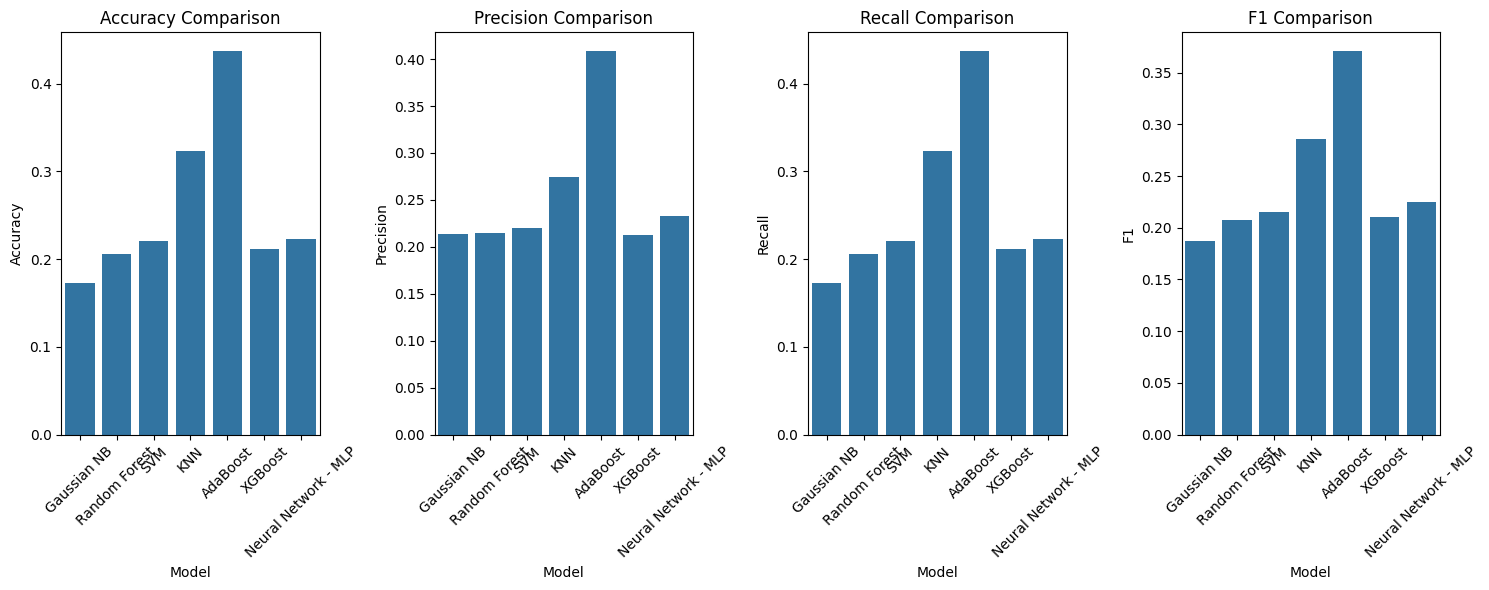

In [5]:
# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=results, x='Model', y=metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()